In [1]:
import pandas as pd
from pathlib import Path

csvPath = Path.cwd()/'audioSampleFiles/metadata.csv'

# Read metadata file
df = pd.read_csv(csvPath)
#df.head()
#df.get('className')

torch.Size([2, 64000])


/home/siotrad/anaconda3/envs/py3/lib/python3.8/site-packages/torchaudio/functional/functional.py:594: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(


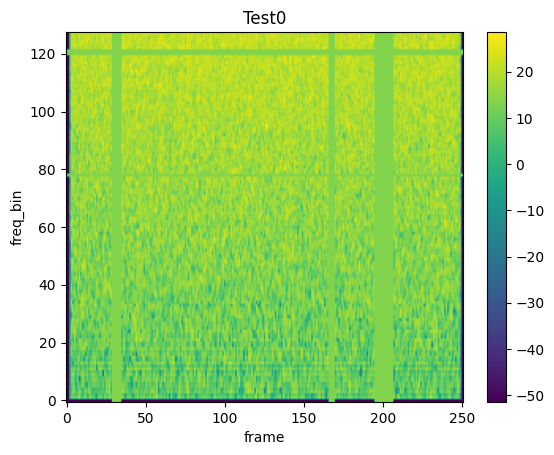

In [2]:
import scipy.io
import matplotlib.pyplot as plot
from scipy.io import wavfile
import librosa
from torch.utils.data import Dataset
import torchaudio
from torchaudio import transforms


class AudioUtilities():
    # ----------------------------
    # Load an audio file. Return the signal as a tensor and the sample rate
    # ----------------------------
    @staticmethod
    def open(fullPath):
        signal, samplingRate = torchaudio.load(fullPath)
        return (signal, samplingRate)
    # ----------------------------
    # Generate a Spectrogram
    # ----------------------------
    @staticmethod
    def genSpectrogram(audio, numMels, numFft, hopLength):
        signal,samplingRate = audio
        maxDB = 80

        # spec has shape [channel, n_mels, time], time = n_fft // 2 + 1
        spectrogram = transforms.MelSpectrogram(samplingRate, n_fft=numFft, hop_length=hopLength, n_mels=numMels)(signal)
        #print(spectrogram.shape)
        
        # Convert to decibels
        spectrogram = transforms.AmplitudeToDB(top_db=maxDB)(spectrogram)
        #print(spectrogram.shape)
        return (spectrogram)
    # ----------------------------
    # For better generalisation, we will implement frequency and time masking at 1 mask at 10% of frequencies and of steps
    # ----------------------------
    @staticmethod
    def augmentSpectrogram(spectrogram, maxMaskingRate, numFreqMasks, numTimeMasks):
        _, numMels, numSteps = spectrogram.shape
        maskValue = spectrogram.mean()
        augmentedSpectrogram = spectrogram

        frequencyMaskParameters = maxMaskingRate * numMels
        for _ in range(numFreqMasks):
            augmentedSpectrogram = transforms.FrequencyMasking(frequencyMaskParameters)(augmentedSpectrogram, maskValue)

        timeMaskParameters = maxMaskingRate * numSteps
        for _ in range(numTimeMasks):
            augmentedSpectrogram = transforms.TimeMasking(timeMaskParameters)(augmentedSpectrogram, maskValue)

        return augmentedSpectrogram
    # ----------------------------
    # Plot out spectrogram to view
    # ----------------------------
    def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
        fig, axs = plot.subplots(1, 1)
        axs.set_title(title or 'Spectrogram (db)')
        axs.set_ylabel(ylabel)
        axs.set_xlabel('frame')
        im = axs.imshow(spec, origin='lower', aspect=aspect)
        if xmax:
            axs.set_xlim((0, xmax))
        fig.colorbar(im, ax=axs)
        plot.show(block=False)
    
audio = torchaudio.load(Path.cwd()/"audioSampleFiles/readySamples/lockpicking/pick1_2B.wav")
signal, samplingRate = audio
#print(samplingRate)
print(signal.shape)

spectrogram = AudioUtilities.genSpectrogram(audio, numMels=128, numFft=512, hopLength=None)
augmentedSpectrogram = AudioUtilities.augmentSpectrogram(spectrogram, maxMaskingRate=0.05, numFreqMasks=3, numTimeMasks=3)

AudioUtilities.plot_spectrogram(augmentedSpectrogram[0], title="Test0")

In [3]:
# ----------------------------
# Creating our custom Sound Dataset
# ----------------------------
class SoundDataSet(Dataset):
    def __init__(self, df, dataPath):
        self.df = df
        self.dataPath = str(dataPath)
                        
    # ----------------------------
    # Number of items in dataset
    # ----------------------------
    def __len__(self):
        return len(self.df)        
        
    # ----------------------------
    # Get i'th item in dataset
    # ----------------------------
    def __getitem__(self, idx):
        # Absolute file path of the audio file
        pathToAudio = self.dataPath + "/" + self.df.loc[idx, 'className'] + "/" + self.df.loc[idx, 'sampleName']
        # Get the serial number of the class the file belongs to
        classSerial = self.df.loc[idx, 'classSerial']
        #print(classSerial)

        audio = AudioUtilities.open(pathToAudio)
        
        spectrogram = AudioUtilities.genSpectrogram(audio, numMels=128, numFft=512, hopLength=None)
        augmentedSpectrogram = AudioUtilities.augmentSpectrogram(spectrogram, maxMaskingRate=0.05, numFreqMasks=3, numTimeMasks=3)

        return augmentedSpectrogram, classSerial

In [4]:
from torch.utils.data import  DataLoader, random_split
import numpy as np
from tensorflow.keras.utils import to_categorical

dataPath = Path.cwd()/'audioSampleFiles/readySamples'
dataset = SoundDataSet(df, dataPath)

# Random split of 80:20 between training and validation
itemsCount = len(dataset)
trainCount = round(itemsCount * 0.8)
testCount = itemsCount - trainCount
trainDataSet, testDataSet = random_split(dataset, [trainCount, testCount])
#print(testCount)

# Create training and validation data loaders
trainDataLoader = DataLoader(trainDataSet, batch_size=trainDataSet.__len__(), shuffle=True)
testDataLoader = DataLoader(testDataSet, batch_size=testDataSet.__len__(), shuffle=False)

for inputs, labels in testDataLoader:
    #print("test")
    #print(labels.shape)
    print(inputs.shape)

trainData, trainLabels = next(iter(trainDataLoader))
testData, testLabels = next(iter(testDataLoader))

#Conversion into class labels
trainLabels = trainLabels.numpy()
trainLabels = to_categorical(trainLabels, num_classes = 3)
testLabels = testLabels.numpy()
testLabels = to_categorical(testLabels, num_classes = 3)

#Transposing the data
trainData = trainData.numpy()
trainData = np.transpose(trainData,(0,2,3,1))
testData = testData.numpy()
testData = np.transpose(testData,(0,2,3,1))

trainMean = np.mean(trainData)
trainStd = np.std(trainData)
trainData = (trainData - trainMean) / trainData

testMean = np.mean(testData)
testStd = np.std(testData)
testData = (testData - testMean) / testData

torch.Size([533, 2, 128, 251])


In [5]:
print(trainLabels)

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]


In [6]:
# load_model loads a model from a hd5 file.
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D
import os

MODEL_NAME = 'audio-cnn.hd5'

def buildmodel(modelName):
    if os.path.exists(modelName):
        print("loading")
        model = load_model(modelName)                                                                                             
    else:
        model = Sequential()
        model.add(Conv2D(32, kernel_size=(5,5), strides=2, activation='relu', input_shape=(128, 251, 2), padding='same'))

        model.add(AveragePooling2D(pool_size=(2,2), strides=2, padding="same"))
        model.add(Conv2D(64, kernel_size=(5,5), strides=2, activation='relu', padding='same'))
        model.add(Conv2D(128, kernel_size=(5,5), strides=2, activation='relu', padding='same'))
        model.add(Conv2D(256, kernel_size=(5,5), strides=2, activation='relu', padding='same'))
        model.add(MaxPooling2D(pool_size=(2,2), strides=2))
        model.add(Flatten())
        model.add(Dense(1024, activation='relu'))
        model.add(Dropout(0.1))
        model.add(Dense(3, activation='softmax'))

    return model
                
test = buildmodel(MODEL_NAME)
test.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 126, 32)       1632      
_________________________________________________________________
average_pooling2d (AveragePo (None, 32, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 32, 64)        51264     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 16, 128)        204928    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 8, 256)         819456    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 4, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0

In [7]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def train(model, trainData, trainLabels, epochs, testData, testLabels, modelName):

    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='categorical_crossentropy', metrics=['accuracy'])

    savemodel = ModelCheckpoint(modelName)
    stopmodel = EarlyStopping(min_delta=0.001, patience=10)

    print("Starting training.")

    model.fit(
        x=trainData, y=trainLabels, batch_size=128,
        validation_data=(testData, testLabels), 
        shuffle=True, epochs=trainData.shape[0]//128, callbacks=[savemodel, stopmodel])

    print("Done. Now evaluating.")
    loss, acc = model.evaluate(x=testData, y=testLabels)
    print("Test accuracy: %3.2f, loss: %3.2f"%(acc, loss))

In [8]:
model = buildmodel(MODEL_NAME)
train(model, trainData, trainLabels, 5, testData, testLabels, MODEL_NAME)

Starting training.
Epoch 1/16
17/17 [==============================] - 21s 1s/step - loss: 1.9138 - accuracy: 0.5450 - val_loss: 1.1404 - val_accuracy: 0.6529
INFO:tensorflow:Assets written to: audio-cnn.hd5/assets
Epoch 2/16
17/17 [==============================] - 18s 1s/step - loss: 0.8188 - accuracy: 0.6903 - val_loss: 0.9484 - val_accuracy: 0.6510
INFO:tensorflow:Assets written to: audio-cnn.hd5/assets
Epoch 3/16
17/17 [==============================] - 17s 992ms/step - loss: 0.6719 - accuracy: 0.6992 - val_loss: 0.9574 - val_accuracy: 0.6510
INFO:tensorflow:Assets written to: audio-cnn.hd5/assets
Epoch 4/16
17/17 [==============================] - 17s 993ms/step - loss: 0.5502 - accuracy: 0.7081 - val_loss: 0.8295 - val_accuracy: 0.6473
INFO:tensorflow:Assets written to: audio-cnn.hd5/assets
Epoch 5/16
17/17 [==============================] - 17s 1s/step - loss: 0.4122 - accuracy: 0.7985 - val_loss: 0.6763 - val_accuracy: 0.7674
INFO:tensorflow:Assets written to: audio-cnn.hd5/as